In [89]:
cd ~/data/modl_data/pipeline/contrast/prediction/4/

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/4


In [90]:
from sklearn.externals.joblib import load
from sklearn.pipeline import Pipeline
import pandas as pd

from nilearn.input_data import MultiNiftiMasker
from nilearn.datasets import load_mni152_brain_mask
from modl.datasets.hcp import fetch_hcp

In [91]:
def plot_confusion_matrix(conf_arr, labels):

    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    S = conf_arr.sum(axis=0)
    S[S == 0] = 1
    conf_arr = conf_arr / S
    
    res = ax.imshow(conf_arr,
                interpolation='nearest')

    width, height = conf_arr.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)
    
def plot_gram_matrix(G, labels):
    fig = plt.figure(figsize=(8, 8))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(G,
                interpolation='nearest')

    width, height = G.shape

    plt.xticks(range(width))
    plt.yticks(range(height))
    ax.set_yticklabels(labels)
    ax.set_xticklabels(labels, rotation=90)
    fig.colorbar(res)

In [92]:
cd _artifacts

/storage/store/work/amensch/data/modl_data/pipeline/contrast/prediction/4/_artifacts


In [93]:
from modl.fixes import OurModel
estimator = load('estimator.pkl')
label_encoder = load('label_encoder.pkl')
prediction = pd.read_csv('prediction.csv')

pipeline = Pipeline(estimator.steps[:-1])

In [94]:
model = estimator.steps[-1][1].stacked_model_

supervised_layers =  model.layers_by_depth[2]
embedding_layer =  model.layers_by_depth[3][0]

w0 = []
for layer in supervised_layers:
    this_w0, this_b0 = layer.get_weights()
    w0.append(this_w0)
w0 = np.concatenate(w0, axis=1)
w1 = embedding_layer.get_weights()[0]

coef = w1.dot(w0).T

In [95]:
print('Sparsity', (coef == 0).sum() / coef.size)

Sparsity 0.0


In [96]:
match = prediction['true_label'] == prediction['predicted_label']
prediction = prediction.assign(match=match)
prediction.set_index(['fold', 'dataset', 'subject', 'task', 'contrast', 'direction'], inplace=True)
prediction.sort_index(inplace=True)
datasets = prediction.index.get_level_values('dataset').unique().values

In [97]:
labels_list = []
tasks_list = []
for dataset in datasets:
    first_subject = prediction.loc['test', dataset].index.get_level_values('subject')[0]
    data = prediction.loc[('test', dataset, first_subject)]
    labels = data.index.get_level_values('contrast').values
    tasks = data.index.get_level_values('task').values
    labels_list.append(labels)
    tasks_list.append(tasks)
labels = np.concatenate(labels_list)
tasks = np.concatenate(tasks_list)

In [98]:
from sklearn.metrics import confusion_matrix

In [99]:
train_conf = confusion_matrix(prediction.loc['train', 'true_label'],
                        prediction.loc['train', 'predicted_label'], labels=labels)
test_conf = confusion_matrix(prediction.loc['test', 'true_label'],
                        prediction.loc['test', 'predicted_label'], labels=labels)

In [100]:
plot_confusion_matrix(test_conf, labels)

In [101]:
prediction['match'].groupby(level=['fold', 'dataset', 'task', 'contrast']).apply(np.mean)['test']

dataset  task        contrast            
archi    emotional   expression_control      1.000000
                     expression_intention    1.000000
                     expression_sex          0.333333
                     face_control            0.000000
                     face_sex                0.333333
                     face_trusty             1.000000
         localizer   audio                   0.666667
                     calculaudio             1.000000
                     calculvideo             1.000000
                     clicDaudio              0.666667
                     clicDvideo              0.333333
                     clicGaudio              0.666667
                     clicGvideo              0.666667
                     computation             0.333333
                     damier_H                1.000000
                     damier_V                0.666667
                     motor-cognitive         1.000000
         parietal    object_grasp       

In [102]:
prediction['match'].groupby(level=['fold', 'dataset']).apply(np.mean)

fold   dataset
test   archi      0.788889
       hcp        0.724638
train  archi      0.856790
       hcp        0.974235
Name: match, dtype: float64

In [92]:
plt.show()

In [707]:
titles = ["%s: %s" % (task, contrast) for task, contrast in zip(tasks, labels)]

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from nilearn._utils import check_niimg

indices = label_encoder.transform(labels)

imgs = check_niimg(imgs)
imgs.get_data()

plt.close('all')

for i, title in zip(indices, titles):
    plot_stat_map(index_img(imgs, i), title=title, threshold=0)

KeyboardInterrupt: 

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/parietal/amensch/opt/miniconda3/lib/python3.6/site-packages/ipykernel/ipkernel

In [ ]:
indices = label_encoder.transform(labels)
ncoef = coef[indices]
S = np.sqrt((ncoef ** 2).sum(axis=1))
ncoef = ncoef / S[:, np.newaxis]

In [ ]:
G = ncoef.dot(ncoef.T)
plot_gram_matrix(G, labels)

In [619]:
np.mean(w0 == 0),np.mean(w1 == 0)

(0.0, 0.0)

In [620]:
np.histogram(w1)

(array([   34,   223,  1099,  4358,  8492, 10087,  6574,  2116,   493,   124]),
 array([ -5.41468558e-04,  -4.37985052e-04,  -3.34501546e-04,
         -2.31018040e-04,  -1.27534533e-04,  -2.40510271e-05,
          7.94324791e-05,   1.82915985e-04,   2.86399492e-04,
          3.89882998e-04,   4.93366504e-04]))

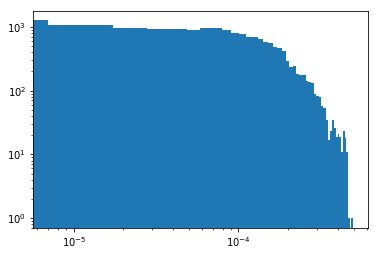

In [623]:
%matplotlib inline
n, bins, patches = plt.hist(w1.ravel(), bins=100, log=True)
plt.xscale('log')

In [ ]:
w1.ravel()[:300]

In [ ]:
(np.abs(coef[indices,:16]).sum())

In [ ]:
(np.abs(coef[indices,16:80])).sum()

In [ ]:
np.abs(coef[indices,80:80 + 256]).sum()

In [ ]:
np.mean(coef[indices, :16] == 0)

In [ ]:
np.mean(coef[indices, 16:80] == 0)

In [ ]:
np.mean(coef[indices, 80:256] == 0)